In [1]:
import sys

PWD = '..'
sys.path.append(PWD)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from src.plot_utils import plot_sample
from src.cfd import CFD
from src.cfd_utils import TIME_STEP, plot_diff_hist_stats

In [2]:
dataset = np.load(f'../data/dataset.npz', allow_pickle=True)

In [3]:
all_X, all_y = dataset['X'], dataset['y']

all_X.shape, all_y.shape

((19570, 64), (19570,))

# Preprocess

In [4]:
n_baseline = 20

In [5]:
all_X -= np.mean(all_X[:, :n_baseline], axis=1)[:, None]

all_X /= all_X.max(axis=1)[:, None]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = all_X, all_X, all_y, all_y # to see the same plots as in prepare_dataset

# Utils

In [7]:
def plot_history(history, title, ymax=None):
    plt.figure(figsize=(10, 7))
    
    X = np.arange(1, len(history['loss']) + 1)
    
    plt.plot(X, history['loss'], label='train')
    plt.plot(X, history['val_loss'], label='test')
    
    if ymax is not None:
        plt.ylim(0, ymax)

    plt.title(f"val loss {history[f'val_loss'].values[-1]:0.4f} (min: {min(history[f'val_loss'].values):0.4f})")
    plt.grid()
    plt.legend()
        
    plt.suptitle(title)
    plt.show()
    
def plot_samples(X, y, y_pred, indices=[10, 11, 12, 13, 500, 1000, 2000, 3000]):
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        plot_sample(X[idx])
        plt.axvline(y[idx], c='red')
        plt.axvline(y_pred[idx], c='orange')
        
        diff = abs(y[idx] - y_pred[idx])
        plt.title(f'Diff: {diff:0.4f} ({diff * TIME_STEP:0.4f}) ns')
        
def plot_difference_hist(y_true, y_pred, channel, hist_range=(-2, 2), n_bins=100):
    mu, std = plot_diff_hist_stats(y_true, y_pred, show=False, n_bins=n_bins, hist_range=hist_range, hist_label=f'', plot_gauss=True, return_gauss_stats=True)

    plt.title(f'Diff histogram (channel={channel}), mean={mu:0.3f}, std={std:0.3f}')
    plt.show()

# CFD

In [8]:
cfd = CFD(fraction=0.23)

y_pred = []
for x in X_test:
    y_pred.append(cfd.predict(x))
    
y_pred = np.array(y_pred)
y_pred.shape

(3914,)

In [9]:
mean_squared_error(y_test, y_pred)

1.133668860542164

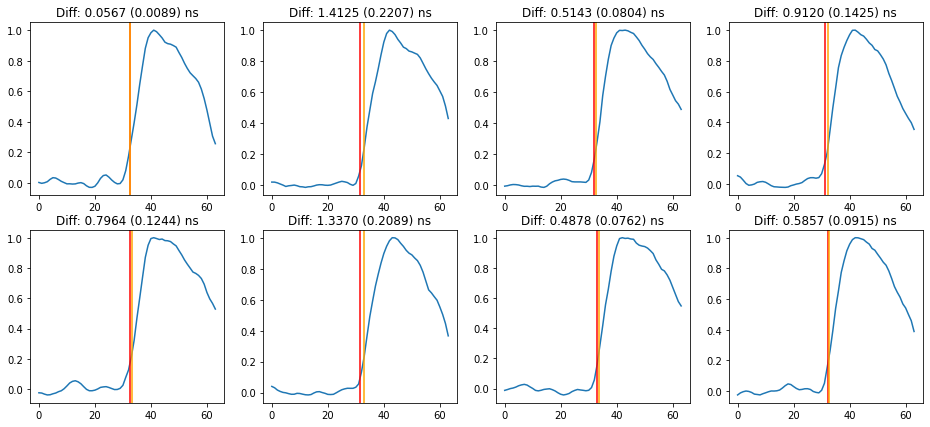

In [10]:
plt.figure(figsize=(16, 7))
plot_samples(X_test, y_test, y_pred)

In [11]:
y_pred.shape

(3914,)

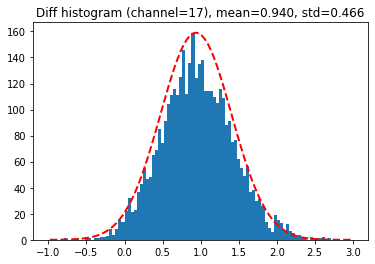

In [12]:
plot_difference_hist(y_test, y_pred, 17, hist_range=(-1, 3))

# Model 1

In [13]:
model = keras.Sequential([
    layers.Input(64),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.1))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50))
model_callbacks.append(callbacks.ModelCheckpoint(filepath='model_weights/nn_experiments/model_1/weights', save_best_only=True, save_weights_only=True))
model_callbacks.append(callbacks.EarlyStopping(patience=200))

# history = model.fit(X_train, y_train, epochs=3000, verbose=1, batch_size=2048, validation_data=(X_test, y_test), callbacks=model_callbacks).history
# pd.DataFrame(history).to_csv('model_weights/nn_experiments/model_1/loss_log.csv')

model.load_weights('model_weights/nn_experiments/model_1/weights')
history = pd.read_csv('model_weights/nn_experiments/model_1/loss_log.csv')

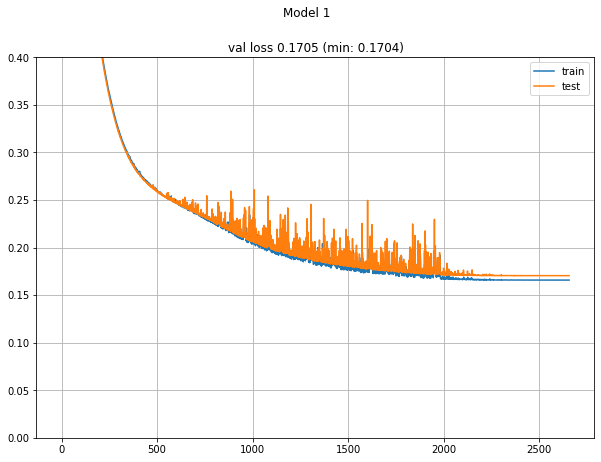

In [14]:
plot_history(history, "Model 1", ymax=0.4)

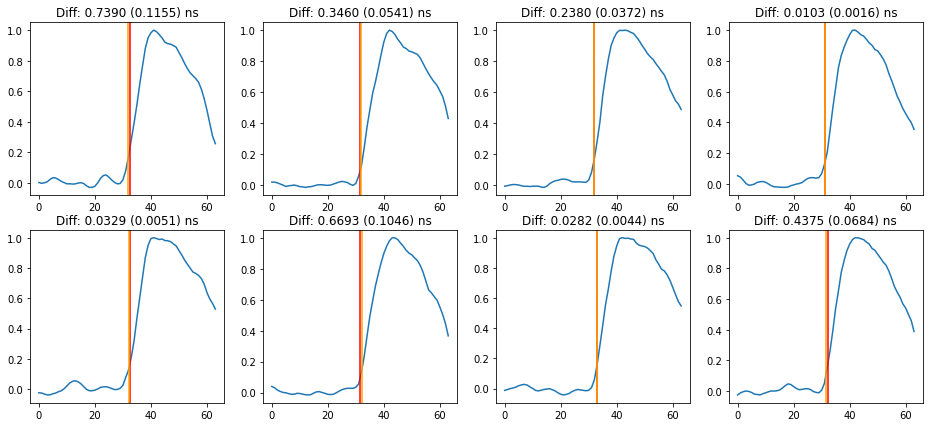

In [15]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

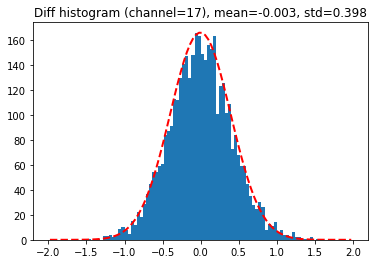

In [16]:
plot_difference_hist(y_test, y_pred, 17)

# Model 2

In [17]:
model = keras.Sequential([
    layers.Input(64),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.01))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50))
model_callbacks.append(callbacks.ModelCheckpoint(filepath='model_weights/nn_experiments/model_2/weights', save_best_only=True, save_weights_only=True))
model_callbacks.append(callbacks.EarlyStopping(patience=200))

# history = model.fit(X_train, y_train, epochs=3000, verbose=1, batch_size=2048, validation_data=(X_test, y_test), callbacks=model_callbacks).history
# pd.DataFrame(history).to_csv('model_weights/nn_experiments/model_2/loss_log.csv')

model.load_weights('model_weights/nn_experiments/model_2/weights')
history = pd.read_csv('model_weights/nn_experiments/model_2/loss_log.csv')

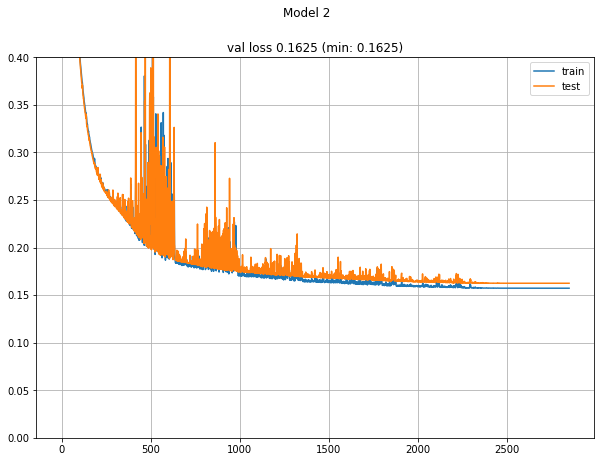

In [18]:
plot_history(history, "Model 2", ymax=0.4)

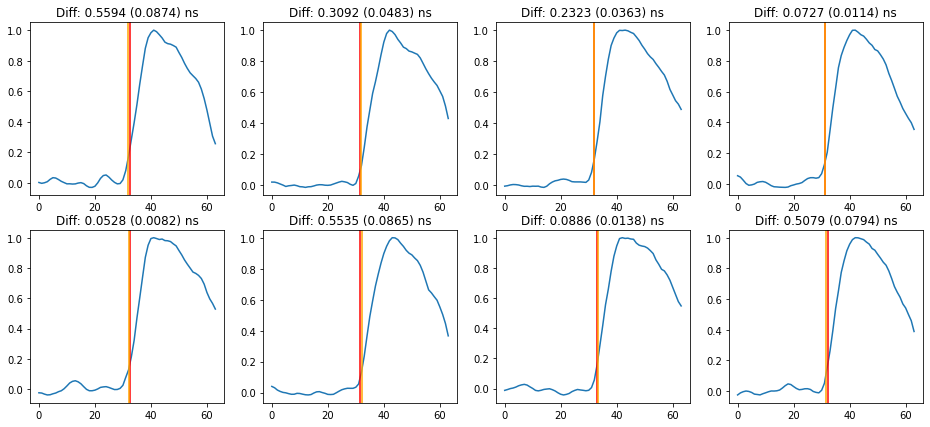

In [19]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

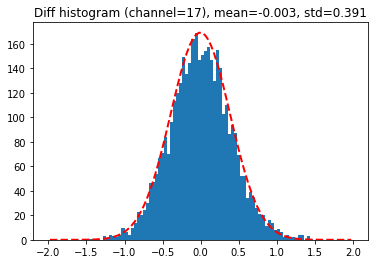

In [20]:
plot_difference_hist(y_test, y_pred, 17)

# Model 3

In [21]:
model = keras.Sequential([
    layers.Input(64),
    layers.Dropout(0.2),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.01))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50))
model_callbacks.append(callbacks.ModelCheckpoint(filepath='model_weights/nn_experiments/model_3/weights', save_best_only=True, save_weights_only=True))
model_callbacks.append(callbacks.EarlyStopping(patience=1000))

# history = model.fit(X_train, y_train, epochs=10000, verbose=1, batch_size=2048, validation_data=(X_test, y_test), callbacks=model_callbacks).history
# pd.DataFrame(history).to_csv('model_weights/nn_experiments/model_3/loss_log.csv')

model.load_weights('model_weights/nn_experiments/model_3/weights')
history = pd.read_csv('model_weights/nn_experiments/model_3/loss_log.csv')

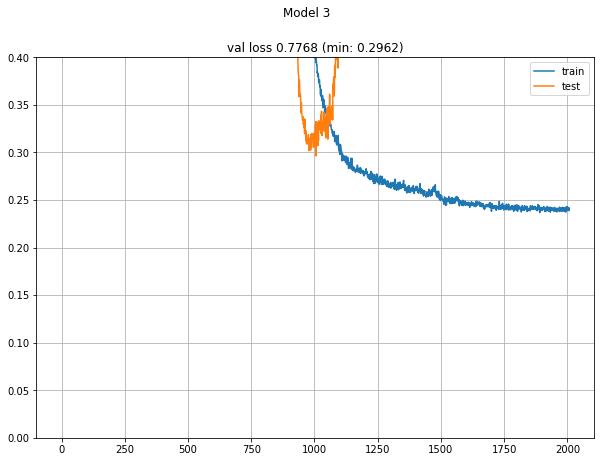

In [22]:
plot_history(history, "Model 3", ymax=0.4)

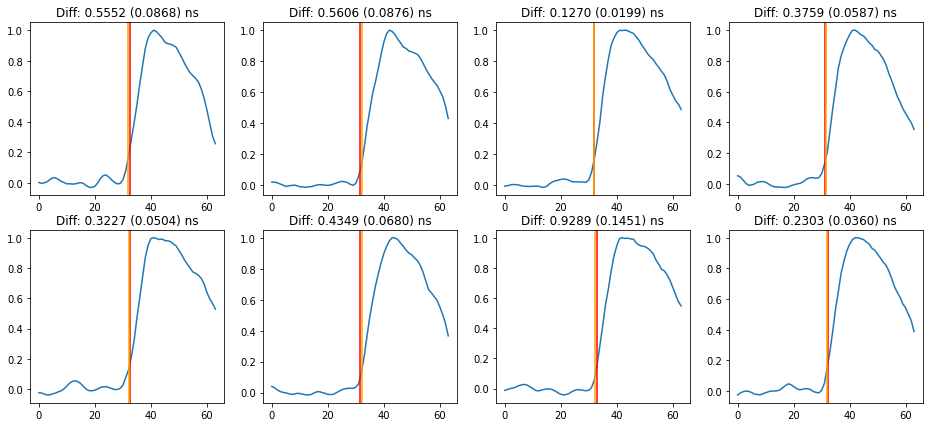

In [23]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

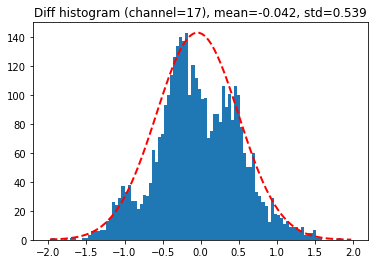

In [24]:
plot_difference_hist(y_test, y_pred, 17)

# Model 4

In [25]:
model = keras.Sequential([
    layers.Input(64),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.01))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50))
model_callbacks.append(callbacks.ModelCheckpoint(filepath='model_weights/nn_experiments/model_4/weights', save_best_only=True, save_weights_only=True))
model_callbacks.append(callbacks.EarlyStopping(patience=200))

# history = model.fit(X_train, y_train, epochs=3000, verbose=1, batch_size=2048, validation_data=(X_test, y_test), callbacks=model_callbacks).history
# pd.DataFrame(history).to_csv('model_weights/nn_experiments/model_4/loss_log.csv')

model.load_weights('model_weights/nn_experiments/model_4/weights')
history = pd.read_csv('model_weights/nn_experiments/model_4/loss_log.csv')

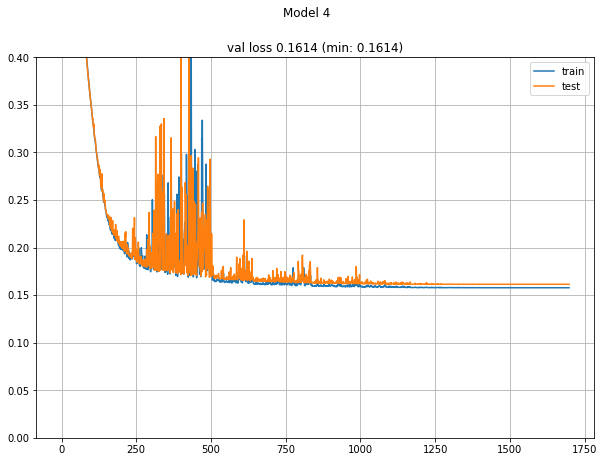

In [26]:
plot_history(history, "Model 4", ymax=0.4)

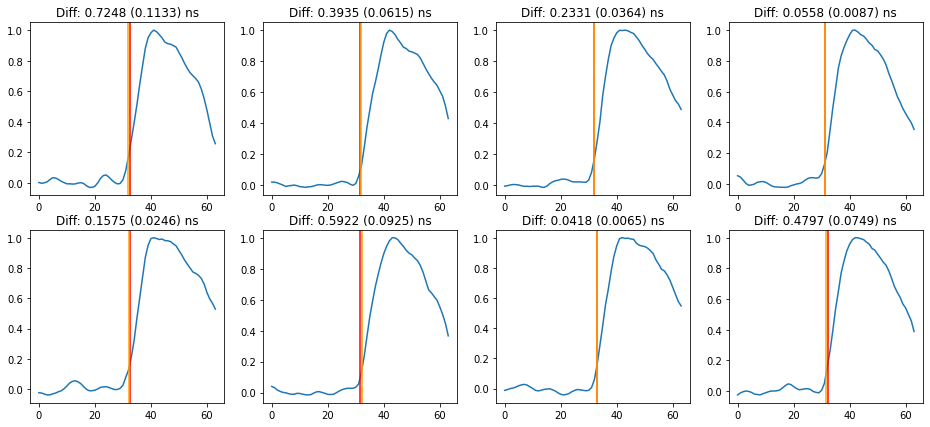

In [27]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

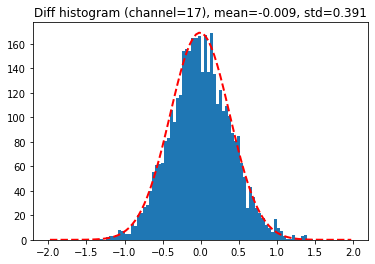

In [28]:
plot_difference_hist(y_test, y_pred, 17)

# Model 5

In [29]:
model = keras.Sequential([
    layers.Input(64),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(32, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(32, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(64, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(64, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(128, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.001))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=100))
model_callbacks.append(callbacks.ModelCheckpoint(filepath='model_weights/nn_experiments/model_5/weights', save_best_only=True, save_weights_only=True))
model_callbacks.append(callbacks.EarlyStopping(patience=500))

# history = model.fit(X_train, y_train, epochs=3000, verbose=1, batch_size=2048, validation_data=(X_test, y_test), callbacks=model_callbacks).history
# pd.DataFrame(history).to_csv('model_weights/nn_experiments/model_5/loss_log.csv')

model.load_weights('model_weights/nn_experiments/model_5/weights')
history = pd.read_csv('model_weights/nn_experiments/model_5/loss_log.csv')

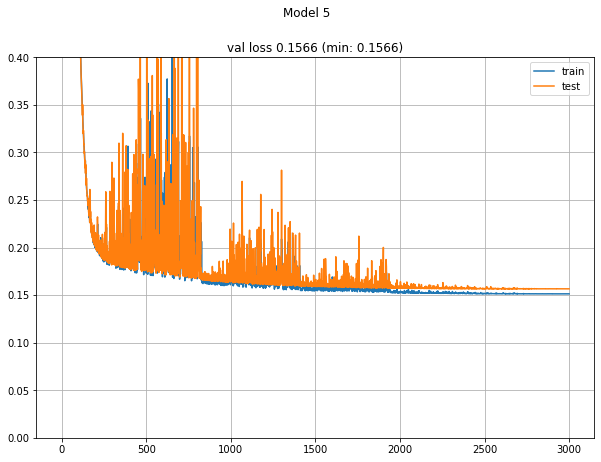

In [30]:
plot_history(history, "Model 5", ymax=0.4)

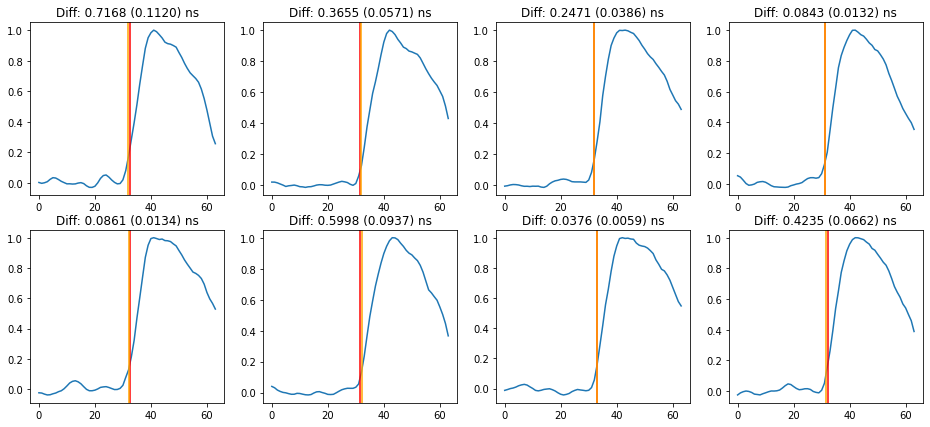

In [31]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

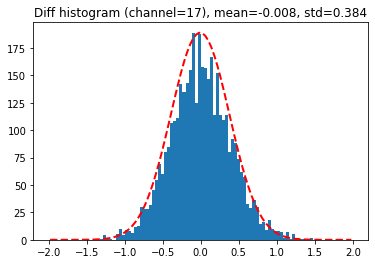

In [32]:
plot_difference_hist(y_test, y_pred, 17)

# Model 6

In [33]:
def residual_block(x, n_filters):
    skip = layers.Conv1D(n_filters, 1, strides=2)(x)
    
    x = layers.Conv1D(n_filters // 4, 1, strides=2)(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv1D(n_filters // 4, 3, padding='same')(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv1D(n_filters, 1)(x)
    
    x = layers.Add()([skip, x])
    x = layers.ReLU()(x)
    
    return x

inputs = layers.Input(64)
x = layers.Reshape((-1, 1))(inputs)

x = residual_block(x, 32)
x = residual_block(x, 64)
x = residual_block(x, 128)
x = residual_block(x, 256)

# x = layers.Flatten()(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

#############################################

model.compile(loss='mse', optimizer=optimizers.Adam(0.001))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=100))
model_callbacks.append(callbacks.ModelCheckpoint(filepath='model_weights/nn_experiments/model_6/weights', save_best_only=True, save_weights_only=True))
model_callbacks.append(callbacks.EarlyStopping(patience=400))

# history = model.fit(X_train, y_train, epochs=5000, verbose=1, batch_size=2048, validation_data=(X_test, y_test), callbacks=model_callbacks).history
# pd.DataFrame(history).to_csv('model_weights/nn_experiments/model_6/loss_log.csv')

model.load_weights('model_weights/nn_experiments/model_6/weights')
history = pd.read_csv('model_weights/nn_experiments/model_6/loss_log.csv')

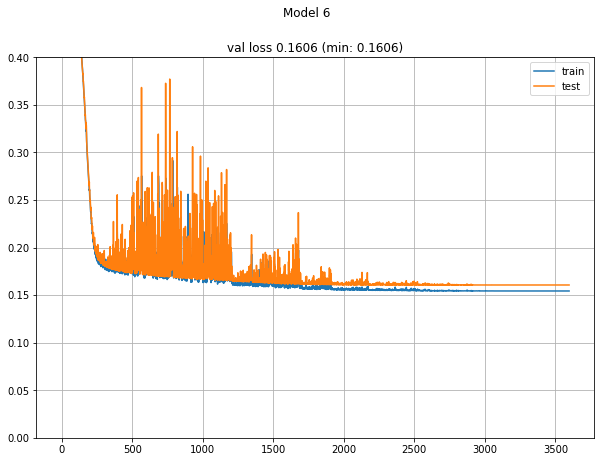

In [34]:
plot_history(history, "Model 6", ymax=0.4)

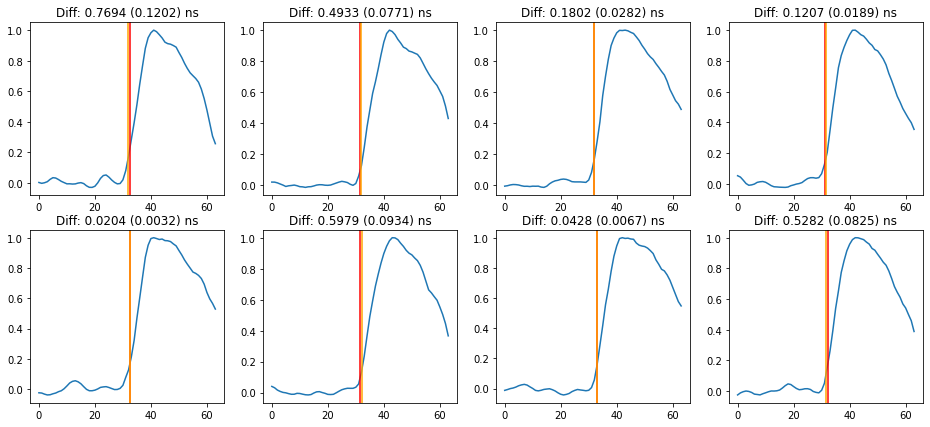

In [35]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

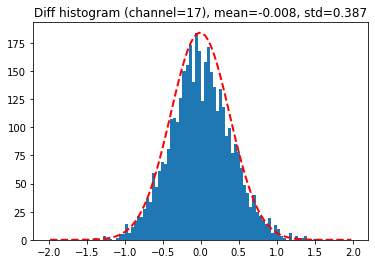

In [36]:
plot_difference_hist(y_test, y_pred, 17)